<a href="https://colab.research.google.com/github/BaDybala/Computational-Physics-Projects/blob/main/Ideal%20Model%20Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import useful modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Simulate a dataset containing $N=20$ data points with independent identically distributed Gaussian noise plus a linear trend.

In [ ]:
# initialise random number generator
rng = np.random.default_rng(seed=1234)
N = 20
# create N x values randomly spaced between -10 and 10
x = rng.uniform(-10,10,N)
#x = np.linspace(-10,10,N)
# randomly select the uncertainty for each observation between 0 and 1
s = rng.uniform(0.1,1.0,len(x))
#s = 0.3
# draw N independent noise values from standard normal distribution
e_ = rng.normal(0,1,len(x))
# rescale to the individual observations' standard deviations
e = e_ * s
# create a tight, regularly spaced grid of x values for plotting
xx = np.linspace(-10,10,100)

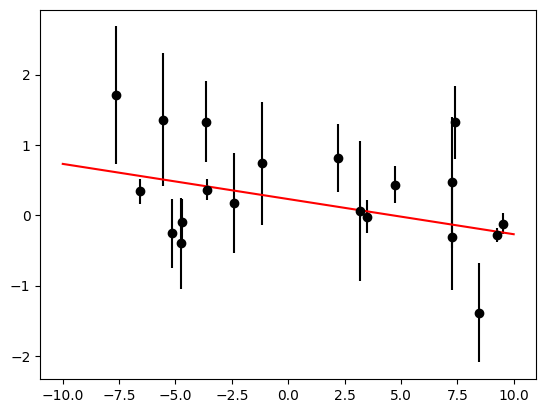

In [ ]:
# select true parameters of our straight line
p_true = [-0.05,0.23] # highest order first
# generate noisy data
#y_obs = p_true[0] * x + p_true[1] + e
y_obs = np.polyval(p_true, x) + e
# true function (for plotting)
yy_true = np.polyval(p_true, xx)
# plot the data and true model
plt.errorbar(x, y_obs, yerr=s, fmt='ko')
plt.plot(xx, yy_true, 'r-');

### Fit the data with a straight line.



In [ ]:
# The easiest way is to use np.polyfit
p_fit = np.polyfit(x, y_obs, 1, w = 1/s**2)
# note how we used the w argument to give the uncertainties.
# w can be a scalar (if all observatoins share the same uncertainty)
# or a vector of the same lenght as x and y_obs

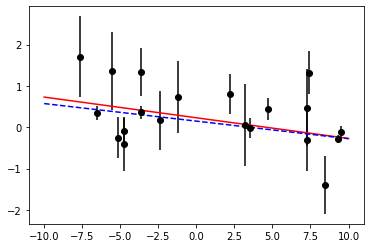

In [ ]:
# plot the results
yy_fit = np.polyval(p_fit, xx)
plt.errorbar(x, y_obs, yerr=s, fmt='ko')
plt.plot(xx, yy_true, 'r-')
plt.plot(xx, yy_fit, 'b--');

### How good is the fit?

In [ ]:
# Evaluate the model at the locations of the observations
y_fit = np.polyval(p_fit, x)
# and the best-fit chi^2
chi2 = (((y_obs-y_fit)/s)**2).sum()
# Print chi2 and no. dofs
print (chi2, N-2)

29.51821491892643 18


In [ ]:
# Compute the quantity Q introduced in the lectures
# Q is the probability of obtaining a value of chi2 at least as large as the value obtained
# For this we need the regularised lower incomplete gamma function.
# Luckily for us, this is implemented in scipy.special as gammaincc
from scipy.special import gammainc
Q = gammainc(chi2/2,(N-2)/2)
print(Q)


0.047895852298303405


With this particular dataset, $Q<5$\%. less than 5\%.

This is not considered so bad as to call the model into question. Something with a 5\% chance of happening does happen once every 20 tries...

### Compare the MLE values of the parameters (slope $a_1$ and intercept $a_2$) to the true values.

In [ ]:
print('Slope: true value = {}, fitted value {}'.format(p_true[0], p_fit[0]))
print('Intercept: true value = {}, fitted value {}'.format(p_true[1], p_fit[1]))


Slope: true value = -0.05, fitted value -0.04245969856984744
Intercept: true value = 0.23, fitted value 0.14903302454183506


### Are the individual parameters consistent with the true values at the 95% confidence level?

To answer this question we need the covariance matrix of the parameters

In [ ]:
# let's re-run polyfit with the cov option
p_fit, cov = np.polyfit(x, y_obs, 1, w = 1/s**2, cov=True)
e_fit = np.sqrt(np.diag(cov)) # this is the array of parameter uncertainties

For a 1-D Gaussian, the symmetric 95\% confidence interval about the mean runs from from $-1.96 \sigma$ to $+1.96 \sigma$



In [ ]:
down = p_fit - 1.96 * e_fit # from mean - 1.96 sigma
up = p_fit + 1.96 * e_fit # to mean + 1.96 sigma
print('Slope: true value = {}, 95% confidence interval {} to {}'.format(p_true[0], down[0], up[0]))
print('Intercept: true value = {}, 95% confidence interval {} to {}'.format(p_true[1], down[1], up[1]))


Slope: true value = -0.05, 95% confidence interval -0.05203198278700087 to -0.032887414352694
Intercept: true value = 0.23, 95% confidence interval 0.06820402187550062 to 0.2298620272081695


In this case the true slope is within the 95% confidence interval but the true intercept lies just outside of it.

There's nothing wrong with our model or our confidence interval estimation as such -- it's just that 5% chance is not that unlikely.

### Plot a 95\% joint confidence region for $a_1$ and $a_2$.


We know such a region will be an ellipse, but it's actually not so easy to work out how to make it the right size, shape and orientation.

I cheated by stealing a routine from the [matplotlib gallery](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html).

That routines takes in a sample of x and y values, works out its sample mean vector and covariance matrix, and then draws the ellipse. In our case, we know the mean vector and covariance matrix, so I modified the routine to take in the mean vector and covariance matrix directly.

The original routine also takes in the number of sigmas at which to plot the ellipse, but here we want a specific confidence level. Luckily we went over how to get the no. sigmas from the confidence level for a 2-D Gaussian during today's lecture.

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def get_confidence_ellipse(mu, cov, level, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse given the mean vector,
    covariance matrix and desired confidence level
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # convert confidence level to no. sigmas
    n_std = np.sqrt(-2 * np.log(1-level))

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse

In [ ]:
def get_nsig(level):
    return n_std


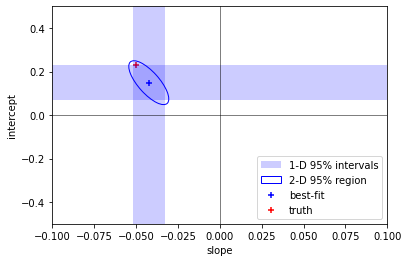

In [ ]:
fig, ax = plt.subplots(1,1)

plt.axvline(0,c='k', lw=0.5)
plt.axhline(0,c='k',lw=0.5)

plt.axvspan(down[0],up[0],color='blue', lw=0, alpha = 0.2, label='1-D 95% intervals')
plt.axhspan(down[1],up[1],color='blue', lw=0, alpha = 0.2)

ell = get_confidence_ellipse(p_fit, cov, 0.95,
                             edgecolor='blue', label = '2-D 95% region')
ax.add_patch(ell)

plt.scatter(p_fit[0], p_fit[1], marker = '+', c='blue', s=30, label = 'best-fit')
plt.scatter(p_true[0], p_true[1], marker = '+', c='red', s=30, label = 'truth')

plt.xlim(-0.1, 0.1)
plt.ylim(-0.5,0.5)
plt.xlabel('slope')
plt.ylabel('intercept')
plt.legend(loc='lower right');

As we can see, the true value falls well within the 95% 2-D confidence region.

## Fit the data with a second order polynomial. Is the fit better? Which model is preferred?

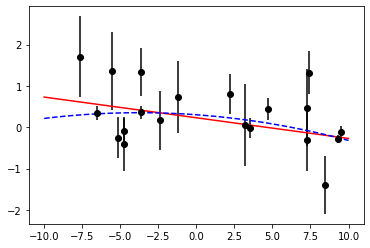

In [ ]:
p_fit = np.polyfit(x, y_obs, 2, w = 1/s**2)
yy_fit = np.polyval(p_fit, xx)
plt.errorbar(x, y_obs, yerr=s, fmt='ko')
plt.plot(xx, yy_true, 'r-')
plt.plot(xx, yy_fit, 'b--');

In [ ]:
y_fit = np.polyval(p_fit, x)
chi2_new = (((y_obs-y_fit)/s)**2).sum()
print (chi2/(N-2), chi2_new/(N-3))

1.639900828829246 1.5606895634325213


So formally the quadratic fit is somewhat better than the linear one, but is it preferred?

In [ ]:
BIC1 = 2 * np.log(N) + chi2
BIC2 = 3 * np.log(N) + chi2_new
print(BIC1, BIC2, BIC1-BIC2)

35.50967946603441 35.518919399014834 -0.009239932980420917


Actually there's not much between them. Let's try increasing $N$

235.63262992302268 244.4662068273584 -8.833576904335729


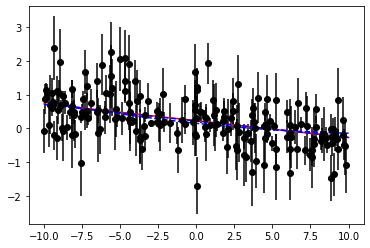

In [ ]:
N = 200
x = rng.uniform(-10,10,N)
s = rng.uniform(0.1,1.0,len(x))
e_ = rng.normal(0,1,len(x))
e = e_ * s
y_obs = np.polyval(p_true, x) + e
yy_true = np.polyval(p_true, xx)
plt.errorbar(x, y_obs, yerr=s, fmt='ko')
plt.plot(xx, yy_true, 'r-')

# linear fit
p1 = np.polyfit(x, y_obs, 1, w = 1/s**2)
yy1 = np.polyval(p1, xx)
plt.plot(xx, yy1, 'b--');
yf1 = np.polyval(p1, x)
chi21 = (((y_obs-yf1)/s)**2).sum()
BIC1 = 2 * np.log(N) + chi21

# quadratic fit
p2 = np.polyfit(x, y_obs, 2, w = 1/s**2)
yy2 = np.polyval(p2, xx)
yf2 = np.polyval(p2, x)
plt.plot(xx, yy2, 'b--');
chi22 = (((y_obs-yf2)/s)**2).sum()
BIC2 = 3 * np.log(N) + chi22

print(BIC1, BIC2, BIC1-BIC2)

With more data, the support for the correct model over the incorrect one increases.